**Mnist Pytorch**

Install pytorch

In [1]:
!pip3 install torch torchvision

In [0]:
import torch
import torchvision
import torchvision.datasets as tds
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import transforms

In [0]:
device = torch.device("cuda:0")

In [4]:
data_train = tds.MNIST('./', 
                       transform = transforms.Compose([transforms.ToTensor()]),
                       download=True)

data_test = tds.MNIST('./', 
                      train=False, 
                      transform = transforms.Compose([transforms.ToTensor()]),
                      download=True)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [0]:
batch_size = 32

validation_size = .2

data_size = data_train.data.shape[0]
split = int(np.floor(validation_size * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[:split], indices[split:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

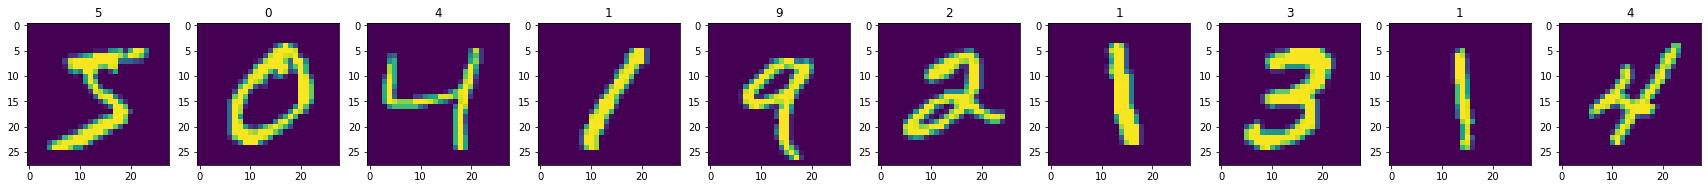

In [6]:
def visualize(data, count=10):
  plt.figure(figsize=(30, 3))
  for i, (X, y) in enumerate(data):
    if i == count:
      break
    plt.subplot(1, 10, i + 1)
    plt.title(y)
    plt.imshow(X)

visualize(tds.MNIST('./', download=True))

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
  train_loss_history = []
  train_history = []
  val_histroy = []

  for i_epoch in range(num_epochs):
    model.train()

    train_loss_sum = 0
    correct_samples = 0
    all_samples = 0

    for i_step, (x, y) in enumerate(train_loader):
      x_gpu = x.to(device)
      y_gpu = y.to(device)
      prediction = model(x_gpu)
      step_loss = loss(prediction, y_gpu)
      optimizer.zero_grad()
      step_loss.backward()
      optimizer.step()

      y_hat = torch.argmax(prediction, 1)
      correct_samples += torch.sum(y_hat == y_gpu)
      all_samples += y.shape[0]
      train_loss_sum += step_loss
    
    train_loss = train_loss_sum / i_step
    train_accuracy = float(correct_samples) / all_samples
    val_accuracy = compute_accuracy(model, val_loader)

    train_loss_history.append(train_loss)
    train_history.append(train_accuracy)
    val_histroy.append(val_accuracy)

    print('Epoch num: %f, Train loss: %f, Train accuracy: %f, Validation accuracy: %f' % (i_epoch, train_loss, train_accuracy, val_accuracy))
  
  return train_loss_history, train_history, val_histroy

def compute_accuracy(model, loader):
  correct_samples = 0
  all_samples = 0

  for i_step, (x, y) in enumerate(loader):
    x_gpu = x.to(device)
    y_gpu = y.to(device)
    prediction = model(x_gpu)

    y_hat = torch.argmax(prediction, 1)
    correct_samples += torch.sum(y_hat == y_gpu)
    all_samples += y.shape[0]
    
  accuracy = float(correct_samples) / all_samples

  return accuracy

In [0]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        new_x = x.view(batch_size, -1)
        return new_x

In [0]:
model = nn.Sequential(
          nn.Conv2d(1, 6, 5, padding=2),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(2, stride=2),
          nn.Conv2d(6, 16, 5),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(2, stride=2),
          Flattener(),
          nn.Linear(400, 120),
          nn.ReLU(inplace=True),
          nn.Linear(120, 84),
          nn.ReLU(inplace=True),
          nn.Linear(84, 10)
)

model.type(torch.cuda.FloatTensor)
model.to(device)
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-4)

In [17]:
train_loss_history, train_history, val_histroy = train_model(model, train_loader, val_loader, loss, optimizer, 10)

Epoch num: 0.000000, Train loss: 1.156520, Train accuracy: 0.594417, Validation accuracy: 0.932229
Epoch num: 1.000000, Train loss: 0.176245, Train accuracy: 0.944083, Validation accuracy: 0.957396
Epoch num: 2.000000, Train loss: 0.111489, Train accuracy: 0.964167, Validation accuracy: 0.938208
Epoch num: 3.000000, Train loss: 0.084100, Train accuracy: 0.973500, Validation accuracy: 0.967792
Epoch num: 4.000000, Train loss: 0.063609, Train accuracy: 0.980333, Validation accuracy: 0.973729
Epoch num: 5.000000, Train loss: 0.054280, Train accuracy: 0.981917, Validation accuracy: 0.974812
Epoch num: 6.000000, Train loss: 0.039716, Train accuracy: 0.987167, Validation accuracy: 0.976125
Epoch num: 7.000000, Train loss: 0.033930, Train accuracy: 0.989750, Validation accuracy: 0.967979
Epoch num: 8.000000, Train loss: 0.028494, Train accuracy: 0.990083, Validation accuracy: 0.980229
Epoch num: 9.000000, Train loss: 0.021496, Train accuracy: 0.992667, Validation accuracy: 0.978042


In [14]:
test_loader = torch.utils.data.DataLoader(data_test)
test_accuracy = compute_accuracy(model, test_loader)
print('Test accuracy: %f' % (test_accuracy))

Test accuracy: 0.980400
